# Object Detection with KerasCV

**Author:** [lukewood](https://twitter.com/luke_wood_ml), Ian Stenbit, Tirth Patel<br>
**Date created:** 2023/04/08<br>
**Last modified:** 2023/08/10<br>
**Description:** Train an object detection model with KerasCV.

KerasCV offers a complete set of production grade APIs to solve object detection
problems.
These APIs include object-detection-specific
data augmentation techniques, Keras native COCO metrics, bounding box format
conversion utilities, visualization tools, pretrained object detection models,
and everything you need to train your own state of the art object detection
models!

Let's give KerasCV's object detection API a spin.

In [1]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.5 MB/s eta 0:00:00


In [2]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

## Object detection introduction

Object detection is the process of identifying, classifying,
and localizing objects within a given image.  Typically, your inputs are
images, and your labels are bounding boxes with optional class
labels.
Object detection can be thought of as an extension of classification, however
instead of one class label for the image, you must detect and localize an
arbitrary number of classes.

**For example:**

<img width="300" src="https://i.imgur.com/8xSEbQD.png">

The data for the above image may look something like this:
```python
image = [height, width, 3]
bounding_boxes = {
  "classes": [0], # 0 is an arbitrary class ID representing "cat"
  "boxes": [[0.25, 0.4, .15, .1]]
   # bounding box is in "rel_xywh" format
   # so 0.25 represents the start of the bounding box 25% of
   # the way across the image.
   # The .15 represents that the width is 15% of the image width.
}
```

Since the inception of [*You Only Look Once*](https://arxiv.org/abs/1506.02640)
(aka YOLO),
object detection has primarily been solved using deep learning.
Most deep learning architectures do this by cleverly framing the object detection
problem as a combination of many small classification problems and
many regression problems.

More specifically, this is done by generating many anchor boxes of varying
shapes and sizes across the input images and assigning them each a class label,
as well as `x`, `y`, `width` and `height` offsets.
The model is trained to predict the class labels of each box, as well as the
`x`, `y`, `width`, and `height` offsets of each box that is predicted to be an
object.

**Visualization of some sample anchor boxes**:

<img width="400" src="https://i.imgur.com/cJIuiK9.jpg">

Objection detection is a technically complex problem but luckily we offer a
bulletproof approach to getting great results.
Let's do this!

## Perform detections with a pretrained model

![](https://storage.googleapis.com/keras-hub/getting_started_guide/prof_keras_beginner.png)

The highest level API in the KerasCV Object Detection API is the `keras_cv.models` API.
This API includes fully pretrained object detection models, such as
`keras_cv.models.YOLOV8Detector`.

Let's get started by constructing a YOLOV8Detector pretrained on the `pascalvoc`
dataset.

In [3]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

100%|██████████| 2.27k/2.27k [00:00<00:00, 3.50MB/s]


100%|██████████| 99.5M/99.5M [00:02<00:00, 50.3MB/s]


Notice the `bounding_box_format` argument?

Recall in the section above, the format of bounding boxes:

```
bounding_boxes = {
  "classes": [num_boxes],
  "boxes": [num_boxes, 4]
}
```

This argument describes *exactly* what format the values in the `"boxes"`
field of the label dictionary take in your pipeline.
For example, a box in `xywh` format with its top left corner at the coordinates
(100, 100) with a width of 55 and a height of 70 would be represented by:
```
[100, 100, 55, 75]
```

or equivalently in `xyxy` format:

```
[100, 100, 155, 175]
```

While this may seem simple, it is a critical piece of the KerasCV object
detection API!
Every component that processes bounding boxes requires a
`bounding_box_format` argument.
You can read more about
KerasCV bounding box formats [in the API docs](https://keras.io/api/keras_cv/bounding_box/formats/).


This is done because there is no one correct format for bounding boxes!
Components in different pipelines expect different formats, and so by requiring
them to be specified we ensure that our components remain readable, reusable,
and clear.
Box format conversion bugs are perhaps the most common bug surface in object
detection pipelines - by requiring this parameter we mitigate against these
bugs (especially when combining code from many sources).

Next let's load an image:

38790/38790 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


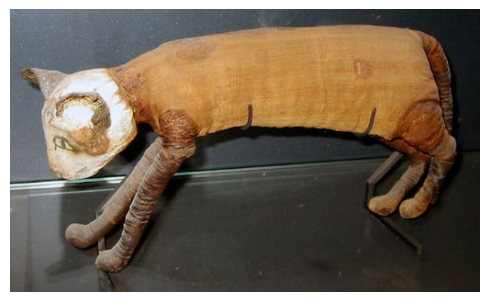

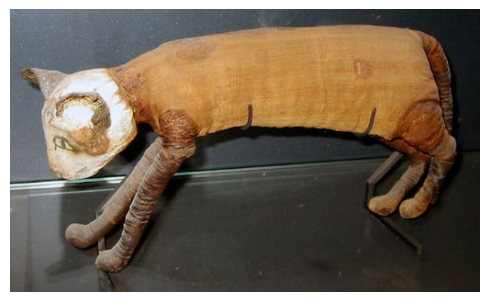

In [47]:
filepath = keras.utils.get_file(origin="https://upload.wikimedia.org/wikipedia/commons/8/87/Louvre_egyptologie_21.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

To use the `YOLOV8Detector` architecture with a ResNet50 backbone, you'll need to
resize your image to a size that is divisible by 64.  This is to ensure
compatibility with the number of downscaling operations done by the convolution
layers in the ResNet.

If the resize operation distorts
the input's aspect ratio, the model will perform signficantly poorer.  For the
pretrained `"yolo_v8_m_pascalvoc"` preset we are using, the final
`MeanAveragePrecision` on the `pascalvoc/2012` evaluation set drops to `0.15`
from `0.38` when using a naive resizing operation.

Additionally, if you crop to preserve the aspect ratio as you do in classification
your model may entirely miss some bounding boxes.  As such, when running inference
on an object detection model we recommend the use of padding to the desired size,
while resizing the longest size to match the aspect ratio.

KerasCV makes resizing properly easy; simply pass `pad_to_aspect_ratio=True` to
a `keras_cv.layers.Resizing` layer.

This can be implemented in one line of code:

In [48]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

This can be used as our inference preprocessing pipeline:

In [49]:
image_batch = inference_resizing([image])

`keras_cv.visualization.plot_bounding_box_gallery()` supports a `class_mapping`
parameter to highlight what class each box was assigned to.  Let's assemble a
class mapping now.

In [50]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Just like any other `keras.Model` you can predict bounding boxes using the
`model.predict()` API.

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


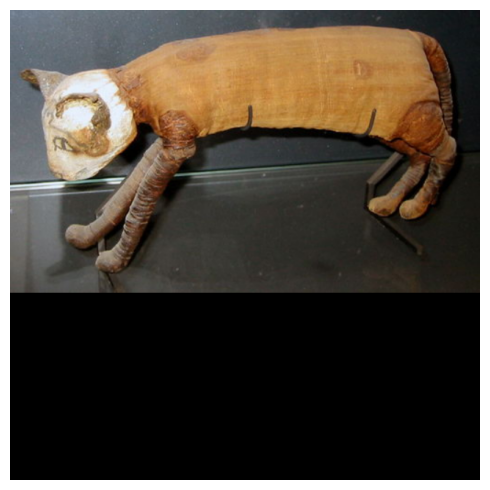

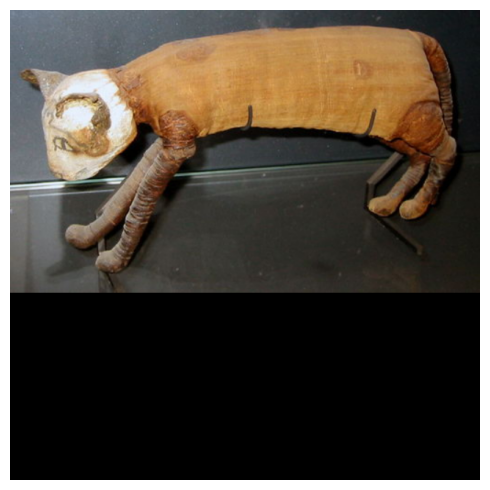

In [51]:
y_pred = pretrained_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

In order to support this easy and intuitive inference workflow, KerasCV
performs non-max suppression inside of the `YOLOV8Detector` class.
Non-max suppression is a traditional computing algorithm that solves the problem
of a model detecting multiple boxes for the same object.

Non-max suppression is a highly configurable algorithm, and in most cases you
will want to customize the settings of your model's non-max
suppression operation.
This can be done by overriding to the `prediction_decoder` argument.

To show this concept off, let's temporarily disable non-max suppression on our
YOLOV8Detector.  This can be done by writing to the `prediction_decoder` attribute.

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_4015']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


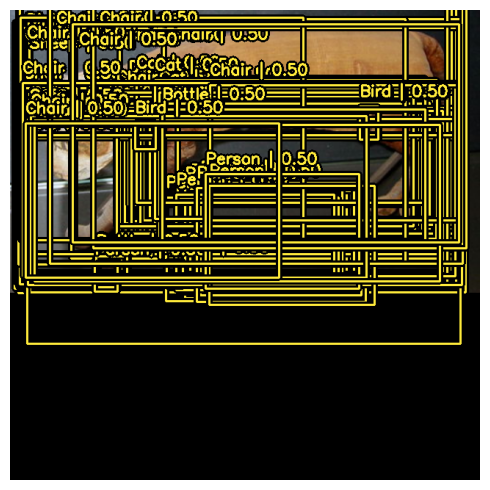

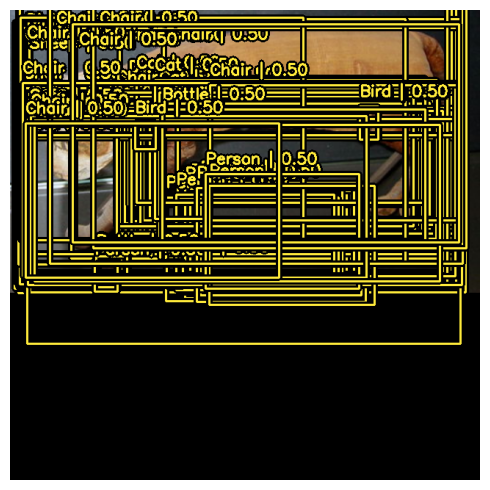

In [52]:
# The following NonMaxSuppression layer is equivalent to disabling the operation
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)


Next, let's re-configure `keras_cv.layers.NonMaxSuppression` for our
use case!
In this case, we will tune the `iou_threshold` to `0.2`, and the
`confidence_threshold` to `0.7`.

Raising the `confidence_threshold` will cause the model to only output boxes
that have a higher confidence score. `iou_threshold` controls the threshold of
intersection over union (IoU) that two boxes must have in order for one to be
pruned out.
[More information on these parameters may be found in the TensorFlow API docs](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_4380']. Received: the structure of inputs=*
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


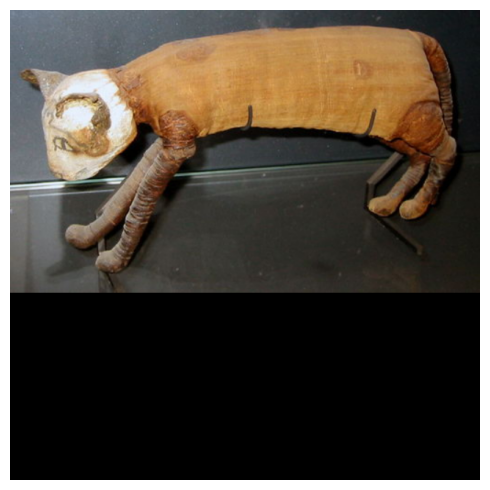

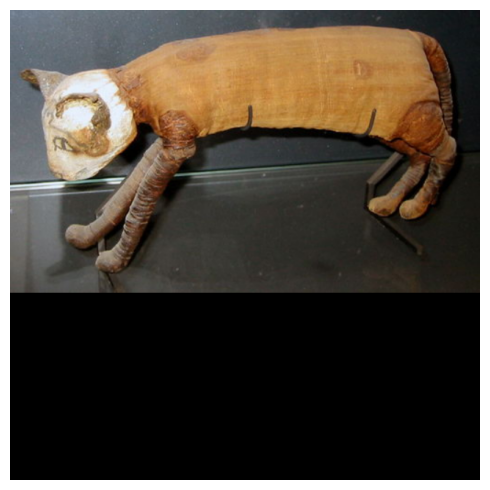

In [53]:
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    # Decrease the required threshold to make predictions get pruned out
    iou_threshold=0.2,
    # Tune confidence threshold for predictions to pass NMS
    confidence_threshold=0.7,
)
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc",
    bounding_box_format="xywh",
    prediction_decoder=prediction_decoder,
)

y_pred = pretrained_model.predict(image_batch)
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

That looks a lot better!

## Train a custom object detection model

![](https://storage.googleapis.com/keras-hub/getting_started_guide/prof_keras_advanced.png)

Whether you're an object detection amateur or a well seasoned veteran, assembling
an object detection pipeline from scratch is a massive undertaking.
Luckily, all KerasCV object detection APIs are built as modular components.
Whether you need a complete pipeline, just an object detection model, or even
just a conversion utility to transform your boxes from `xywh` format to `xyxy`,
KerasCV has you covered.

In this guide, we'll assemble a full training pipeline for a KerasCV object
detection model.  This includes data loading, augmentation, metric evaluation,
and inference!

To get started, let's sort out all of our imports and define global
configuration parameters.

In [ ]:
BATCH_SIZE = 4

## Data loading

To get started, let's discuss data loading and bounding box formatting.
KerasCV has a predefined format for bounding boxes.
To comply with this, you
should package your bounding boxes into a dictionary matching the
specification below:

```
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

`bounding_boxes['boxes']` contains the coordinates of your bounding box in a KerasCV
supported `bounding_box_format`.
KerasCV requires a `bounding_box_format` argument in all components that process
bounding boxes.
This is done to maximize your ability to plug and play individual components
into their object detection pipelines, as well as to make code self-documenting
across object detection pipelines.

To match the KerasCV API style, it is recommended that when writing a
custom data loader, you also support a `bounding_box_format` argument.
This makes it clear to those invoking your data loader what format the bounding boxes
are in.
In this example, we format our boxes to `xywh` format.

For example:

```python
train_ds, ds_info = your_data_loader.load(
    split='train', bounding_box_format='xywh', batch_size=8
)
```

This clearly yields bounding boxes in the format `xywh`.  You can read more about
KerasCV bounding box formats [in the API docs](https://keras.io/api/keras_cv/bounding_box/formats/).

Our data comes loaded into the format
`{"images": images, "bounding_boxes": bounding_boxes}`.  This format is
supported in all KerasCV preprocessing components.

Let's load some data and verify that the data looks as we expect it to.

In [ ]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Next, let's batch our data.

In KerasCV object detection tasks it is recommended that
users use ragged batches of inputs.
This is due to the fact that images may be of different sizes in PascalVOC,
as well as the fact that there may be different numbers of bounding boxes per
image.

To construct a ragged dataset in a `tf.data` pipeline, you can use the
`ragged_batch()` method.

In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Let's make sure our dataset is following the format KerasCV expects.
By using the `visualize_dataset()` function, you can visually verify
that your data is in the format that KerasCV expects.  If the bounding boxes
are not visible or are visible in the wrong locations that is a sign that your
data is mis-formatted.

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

And for the eval set:

In [ ]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

Looks like everything is structured as expected.
Now we can move on to constructing our
data augmentation pipeline.

## Data augmentation

One of the most challenging tasks when constructing object detection
pipelines is data augmentation.  Image augmentation techniques must be aware of the underlying
bounding boxes, and must update them accordingly.

Luckily, KerasCV natively supports bounding box augmentation with its extensive
library
of [data augmentation layers](https://keras.io/api/keras_cv/layers/preprocessing/).
The code below loads the Pascal VOC dataset, and performs on-the-fly,
bounding-box-friendly data augmentation inside a `tf.data` pipeline.

In [ ]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
    keras_cv.layers.JitteredResize(
        target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Great! We now have a bounding-box-friendly data augmentation pipeline.
Let's format our evaluation dataset to match.  Instead of using
`JitteredResize`, let's use the deterministic `keras_cv.layers.Resizing()`
layer.

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)

Due to the fact that the resize operation differs between the train dataset,
which uses `JitteredResize()` to resize images, and the inference dataset, which
uses `layers.Resizing(pad_to_aspect_ratio=True)`, it is good practice to
visualize both datasets:

In [ ]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Finally, let's unpackage our inputs from the preprocessing dictionary, and
prepare to feed the inputs into our model.  In order to be TPU compatible,
bounding box Tensors need to be `Dense` instead of `Ragged`.

In [ ]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)

### Optimizer

In this guide, we use a standard SGD optimizer and rely on the
[`keras.callbacks.ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/)
callback to reduce the learning rate.

You will always want to include a `global_clipnorm` when training object
detection models.  This is to remedy exploding gradient problems that frequently
occur when training object detection models.

In [ ]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

To achieve the best results on your dataset, you'll likely want to hand craft a
`PiecewiseConstantDecay` learning rate schedule.
While `PiecewiseConstantDecay` schedules tend to perform better, they don't
translate between problems.

### Loss functions

You may not be familiar with the `"ciou"` loss.  While not common in other
models, this loss is sometimes used in the object detection world.

In short, ["Complete IoU"](https://arxiv.org/abs/1911.08287) is a flavour of the Intersection over Union loss and is used due to its convergence properties.

In KerasCV, you can use this loss simply by passing the string `"ciou"` to `compile()`.
We also use standard binary crossentropy loss for the class head.

In [ ]:
pretrained_model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
)

### Metric evaluation

The most popular object detection metrics are COCO metrics,
which were published alongside the MSCOCO dataset. KerasCV provides an
easy-to-use suite of COCO metrics under the `keras_cv.callbacks.PyCOCOCallback`
symbol. Note that we use a Keras callback instead of a Keras metric to compute
COCO metrics. This is because computing COCO metrics requires storing all of a
model's predictions for the entire evaluation dataset in memory at once, which
is impractical to do during training time.

In [ ]:
coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds.take(20), bounding_box_format="xywh"
)


Our data pipeline is now complete!
We can now move on to model creation and training.

## Model creation

Next, let's use the KerasCV API to construct an untrained YOLOV8Detector model.
In this tutorial we use a pretrained ResNet50 backbone from the imagenet
dataset.

KerasCV makes it easy to construct a `YOLOV8Detector` with any of the KerasCV
backbones.  Simply use one of the presets for the architecture you'd like!

For example:

In [ ]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "resnet50_imagenet",
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
    num_classes=20,
)

That is all it takes to construct a KerasCV YOLOv8. The YOLOv8 accepts
tuples of dense image Tensors and bounding box dictionaries to `fit()` and
`train_on_batch()`

This matches what we have constructed in our input pipeline above.

## Training our model

All that is left to do is train our model.  KerasCV object detection models
follow the standard Keras workflow, leveraging `compile()` and `fit()`.

Let's compile our model:

In [ ]:
model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

If you want to fully train the model, remove `.take(20)` from all dataset
references (below and in the initialization of the metrics callback).

In [ ]:
model.fit(
    train_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[coco_metrics_callback],
)

## Inference and plotting results

KerasCV makes object detection inference simple.  `model.predict(images)`
returns a tensor of bounding boxes.  By default, `YOLOV8Detector.predict()`
will perform a non max suppression operation for you.

In this section, we will use a `keras_cv` provided preset:

In [ ]:
model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)

Next, for convenience we construct a dataset with larger batches:

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

Let's create a simple function to plot our inferences:

In [ ]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


You may need to configure your NonMaxSuppression operation to achieve
visually appealing results.

In [ ]:
model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

Awesome!
One final helpful pattern to be aware of is to visualize
detections in a `keras.callbacks.Callback` to monitor training :

In [ ]:

class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_ds
        )


## Takeaways and next steps

KerasCV makes it easy to construct state-of-the-art object detection pipelines.
In this guide, we started off by writing a data loader using the KerasCV
bounding box specification.
Following this, we assembled a production grade data augmentation pipeline using
KerasCV preprocessing layers in <50 lines of code.

KerasCV object detection components can be used independently, but also have deep
integration with each other.
KerasCV makes authoring production grade bounding box augmentation,
model training, visualization, and
metric evaluation easy.

Some follow up exercises for the reader:

- add additional augmentation techniques to improve model performance
- tune the hyperparameters and data augmentation used to produce high quality results
- train an object detection model on your own dataset

One last fun code snippet to showcase the power of KerasCV's API!

In [ ]:
stable_diffusion = keras_cv.models.StableDiffusionV2(512, 512)
images = stable_diffusion.text_to_image(
    prompt="A zoomed out photograph of a cool looking cat.  The cat stands in a beautiful forest",
    negative_prompt="unrealistic, bad looking, malformed",
    batch_size=4,
    seed=1231,
)
encoded_predictions = model(images)
y_pred = model.decode_predictions(encoded_predictions, images)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    y_pred=y_pred,
    rows=2,
    cols=2,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)